In [2]:
import numpy as np
import pandas as pd
import math

In [3]:
# Carregando dados
# Lista de Umbilicais
dcable = pd.read_excel("DATA_CABLE.xlsx")

In [60]:
# Algoritmo AHP-FUZZY

# Função triangular AHP-FUZZY
triangular_membership_function = {1:[1,1,1] , 2:[1,2,3] , 3:[2,3,4] , 4:[3,4,5] , 5:[4,5,6] , 6: [5,6,7] , 7:[6,7,8],8:[7,8,9],9:[9,9,9]}
#test_data = [[1,5,4,7],[0.2,1,0.5,3],[0.25,2,1,3],[0.142,0.33,0.33,1]]

def fuzzy_AHP(AHP_matrix):
	#print(triangular_membership_function)
	test_data = AHP_matrix
	n = len(test_data)
	fuzzified_test_data = np.zeros((n,n,3))

	for x in range(n):
		for y in range(n):
			if(test_data[x][y] >= 1):
				fuzzified_test_data[x][y] = triangular_membership_function[test_data[x][y]]
			else:
				index = round(1/test_data[x][y])
				#print(index)
				temp = triangular_membership_function[index]
				for i in range(3):
					fuzzified_test_data[x][y][i] = 1.0/temp[2-i]
	#print(fuzzified_test_data)

	fuzzy_geometric_mean = [[1 for x in range(3)] for y in range(n)]
	#print(fuzzy_geometric_mean)

	for i in range(n):
		for j in range(3):
			for k in range(n):
				fuzzy_geometric_mean[i][j] *= fuzzified_test_data[i][k][j]
			fuzzy_geometric_mean[i][j] = fuzzy_geometric_mean[i][j]**(1/float(n))
	#print(fuzzy_geometric_mean)

	sum_fuzzy_gm = [0 for x in range(3)]
	inv_sum_fuzzy_gm = [0 for x in range(3)]

	for i in range(3):
		for j in range(n):
			sum_fuzzy_gm[i] += fuzzy_geometric_mean[j][i]

	for i in range(3):
		inv_sum_fuzzy_gm[i] = (1.0/sum_fuzzy_gm[2-i])
	#print(sum_fuzzy_gm)

	fuzzy_weights = [[1 for x in range(3)] for y in range(n)]

	for i in range(n):
		for j in range(3):
			fuzzy_weights[i][j] = fuzzy_geometric_mean[i][j]*inv_sum_fuzzy_gm[j]
	print(fuzzy_weights)

	weights = [0 for i in range(n)]
	normalized_weights = [0 for i in range(n)]
	sum_weights = 0

	for i in range(n):
		for j in range(3):
			weights[i] += fuzzy_weights[i][j]
		weights[i] /= 3
		sum_weights += weights[i]
	#print(weights)
	#print(sum_weights)

	for i in range(n):
		normalized_weights[i] = (1.0*weights[i])/(1.0*sum_weights)
	#print(normalized_weights)

	return normalized_weights

#if __name__=="__main__":
#	main()

In [5]:
# Algoritmo do Fluxo de potência
# Algoritmo dos custos por circuito
# Algoritmo da escolha da bitola ideial

def Fluxo(D,Vt,Vcabo,FP,P, EFF):
  # Inicio do algoritmo
  # Dados Elétricos
  S = P/(FP*EFF) # Potência aparente da Carga
  I=(S/Vt/(3)**0.5)*1000 # Corrente da carga
  
  #Dados para calculo de custo de instalação
  ton_fac = 300 # peso em tonelada na bobina nas fábricas
  ton_PLSV = 3640 # peso em tonelada no PLSV
  viagem = 2 # numero de dias de viagem
  t_emendas = 1.5 # tempo em dias para emendas
  vel_SPOOL = 17.2 # velocidade km/dia para spool
  vel_PLSV = 8.6 # velocidade km/dia do PLSV
  diaria_PLSV = 275 # custo da diaria do PLSV em U$M

  # Lista de Cabos dependendo da classe de tensão
  # Opção 12/20 kV
  if Vt < 20:
    list_cable = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    Vsmax = Vcabo*1000*0.9 # Tensão máxima de operação
  # Opção 18/30 kV
  elif Vt > 20 and Vt < 36:
    list_cable = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    Vsmax = Vcabo*1000*0.9 # Tensão máxima de operação
  # Opção 36/69 kV
  elif Vt > 36 and Vt < 69:
    list_cable = [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
    Vsmax = Vcabo*1000*0.9 # Tensão máxima de operação
  # Opção 76/138 kV
  elif Vt > 70:
    list_cable = [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
    Vsmax = Vcabo*1000*0.9 # Tensão máxima de operação


  # Escolha do Cabo
  n = 1 # número de cabos por fase
  i = list_cable[0] # inicio da lista de cabos para algoritmo 
  #t = len(list_cable)-1
  #print(t)
  t = list_cable[11] # ffinal da lista de cabos para algoritmo 
  fim = 0
  # Laço para escolha de cabo
  # Inicio com a menor bitola e tenta atender as premissas
  while n < 4:
    num = n
    i = list_cable[0]
    #print(n)
    while  i <= t:
      #print(i)
      R = dcable.loc[i, 'Rca'] # Resistência do cabo Ohms/km
      Xl = dcable.loc[i, 'XL'] # Resistência do cabo Ohms/km
      Xc = dcable.loc[i, 'XC'] # Resistência do cabo Ohms*km
      Icabo1 = dcable.loc[i, 'I-55']  # Corrente nominal a 55°C
    # Fator de agrupamento dependendo do n° de cabos por fase
      if num == 1:
        fcorr = 1
      elif num == 2:
        fcorr = 0.9
      else:
        fcorr = 0.9 

      Icabo = (Icabo1/1.20)*num*fcorr #Corrente nominal com fator de 20%
      
    # Cálculo de Impedância equivalente do Cabo
      Rc = R*D/num
      Xlc = Xl*D/num
      Yc = (1/Xc)*D*num
      ZZ=complex(Rc,Xlc)
      ZZZ=complex(0, Yc)
      Zc=(ZZ/ZZZ)**0.5
      Yl=(ZZ*ZZZ)**0.5
      Zeq = np.sinh(Yl)*Zc
      a = (np.cosh(Yl)-complex(1,0))/Zeq

      # Fluxo de Potência
      Vr = complex(Vt/(3)**0.5*1000,0) # Tensão de saída do umbilical
      Vr3 = Vr*3**0.5 # Tensão trifásica de saída do umbilical
      Ir = complex(I*FP*EFF,-I*(1-(FP*EFF)**2)**0.5) # Corrente de saída do umbilical
      dV = (Vr*a+Ir)*Zeq # Queda de tensão no umbilical
      Vs = Vr+dV # Tensão de entrada do umbilcal
      Vs3 = Vs*3**0.5 # Tensão trifásica de entrada do umbilcal
      Is = (dV/Zeq)+(Vs*a)  # Corrente de entrada do umbilcal
      Ps = Vs*complex.conjugate(Is)  # Potência de entrada do umbilcal
      realPs = Ps.real*3/1000000  # Potência ativa de entrada do umbilcal
      Vsp = (abs(Vs)/Vt/1000)*(3)**0.5*100 # Relação Vs/Vt
      Isp = (abs(Is)/Icabo)*100 # Relação Is/Vr
      Vrp = abs(Vr)/Vt/1000*(3)**0.5*100 # Relação Vr/Vt
      Irp = abs(Ir)/Icabo*100 # Relação Is/Ir
      PerdW = realPs-P # Perdas ao longo do umbilical
      Perd = (PerdW)/P*100 # Relação das Perdas/Potência ativa da carga
      
      
      # Custos
      # Custo de Aquisição dos cabos
      Custo_Aq = dcable.loc[i, 'Custo']*D*num/1000
      # Custo de Instalação dos cabos  
      Peso_umb = dcable.loc[i, 'Peso']*D
      dias_viagem = math.ceil(Peso_umb/ton_PLSV)*viagem
      n_emendas = math.floor(Peso_umb/ton_fac)*num
      dias_emendas = math.ceil(n_emendas*t_emendas)
      dias_spool = math.ceil(D*num/vel_SPOOL)
      dias_inst = math.ceil(D*num/vel_PLSV)
      dias_total = dias_viagem + dias_emendas + dias_spool + dias_inst
      Custo_Ins = dias_total*diaria_PLSV/1000



      #print(dcable.loc[i, 'Bitola'],Vsp,Isp,abs(Vs3), Perd, Custo_Aq)
      
      # Condição para atendimento das premissas
      # Deve atender Is e Ip menor que Icabo com 20% de segurança
      # Deve atender no máximo de 10% de queda de tensão
      # Deve atender no máximo de 7% de Perdas
      if Isp < 100 and Irp <100 and Vsp < 110 and Perd < 7 and abs(Vs3) < Vsmax:
        #Resultado = {'Bitola': ["%.2f" % dcable.loc[i, 'Bitola'],num, "%.2f" % Icabo],'Vs': ["%.2f" %abs(Vs3),"%.2f" %Vsp],'Is': ["%.2f" %abs(Is),"%.2f" %Isp],'Ir': ["%.2f" %abs(Ir),"%.2f" %Irp],'Vr': ["%.2f" %abs(Vr3),"%.2f" %Vrp], 'Perdas': ["%.2f" %PerdW, "%.2f" %Perd ]}
        Resultado = {'D':[D],
                     'Ps':[round(abs(Ps*3/1000000),2)],
                     'Bitola': [round(dcable.loc[i, 'Bitola'],0)],
                     'num':[num],'Vs': [round(abs(Vs3),2)],
                     'Vs%':[round( Vsp,2)],
                     'Is': [round(abs(Is),2)],
                     'Is%':[round(Isp,0)],
                     'Ir': [round(abs(Ir),2)],
                     'Ir%':[round(Irp,0)],
                     'Vr': [round(abs(Vr3),2)],
                     'Vr%':[round(Vrp,2)],
                     'Perdas': [round(PerdW,2)],
                     'Perd%':[round(Perd,2) ],
                     'Preal':[Ps.real],
                     'Pimag':[Ps.imag],
                     'Custo_Aq':[round(Custo_Aq,2)],
                     'Custo_Ins':[Custo_Ins]}
        #s = pd.DataFrame(Resultado)
        fim = 1
        #print (s)
        break
      i = i + 1 
    
    if fim == 1:
      return pd.DataFrame(Resultado)
      break
    n = n +1
    
    

In [8]:
# Carregando dados das localizações das cargas e paineis

dt = pd.read_excel("dist.xlsx")
dt['D'] = ((dt['D_SWGx']-dt['Dx'])**2+(dt['D_SWGy']-dt['Dy'])**2)**0.5 # Calculo da distância entre Painel e Carga
dt

,D_SWGx,D_SWGy,Dx,Dy,D
0,29.761486,4.500000,30.000000,9.000000,4.506316
1,29.761486,4.500000,30.000000,8.000000,3.508117
2,29.761486,4.500000,30.000000,7.000000,2.511352
3,29.761486,4.500000,30.000000,6.000000,1.518844
4,29.761486,4.500000,30.000000,5.000000,0.553975
...,...,...,...,...,...
149,29.329634,2.568593,30.000000,2.000000,0.879027
150,0.000000,4.500000,29.329634,2.568593,29.393158
151,29.325440,4.499728,30.000000,5.000000,0.839823
152,29.325440,4.499728,30.000000,4.000000,0.839499


In [7]:
# Carregando os dados de confiabilidade
dconf = pd.read_excel("Conf.xlsx")
dconf

,I%,R_Eq,R_Umb
0,0.0,0.999969,0.999988
1,1.0,0.999939,0.999939
2,2.0,0.999939,0.999939
3,3.0,0.999939,0.999939
4,4.0,0.999939,0.999939
...,...,...,...
96,96.0,0.749300,0.922918
97,97.0,0.718498,0.912848
98,98.0,0.684218,0.899950
99,99.0,0.646194,0.883648


In [9]:
# DADOS DE ENTRADA: Carga e Sistema

'''
  Este algoritmo executa as seguintes tarefas:
  - Calculo do fluxo de potência de cada circuito;
  - Criação da tabela com todas as alternativas;
  - Somatória das potências de número de circuitos de cada painel;
  - Cálculo da média de tensão de cada painel;
  - Cálculo do FP de cada painel;
  - Criação da tabela com todos os alimentadores e os paineis;
  - Criação da tabela dr, com as informações de Perdas e Potências de cada alternativa;
  - Calculo da confiabilidade de cada ramal;
  - Calculo da confiabilidade do trecho de transmissão;
  - Calculo da confiabilidade total para uma bomba submarina;
  - Calculo da probabilidade de perdas das 10 cargas.

  Os circuitos foram divididos a seguinte forma:

n = 1  -> 1 painel com 10 alimentadores
n = 2  -> 2 paineis com 8 e 2 alimentadores
n = 3  -> 2 paineis com 7 e 3 alimentadores
n = 4  -> 2 paineis com 6 e 4 alimentadores
n = 5  -> 2 paineis com 5 e 5 alimentadores
n = 6  -> 3 paineis com 6, 2 e 2 alimentadores
n = 7  -> 3 paineis com 5, 3 e 2 alimentadores
n = 8  -> 3 paineis com 4, 4 e 2 alimentadores
n = 9  -> 3 paineis com 4, 3 e 3 alimentadores
n = 10 -> 4 paineis com 2, 2, 2 e 4 alimentadores
n = 11 -> 4 paineis com 2, 2, 3 e 3 alimentadores
n = 12 -> 5 paineis com 2, 2, 2, 2 e 2 alimentadores


'''
for n in range(1,13):
 # n == j
  Vt =  25 # Tensão na carga
  Vcabo = 30
  FP = 0.92 # FP da carga
  EFF = 1
  P = 4 # Potência ativa da carga
  b = pd.DataFrame() 
  c = pd.DataFrame()
  d = pd.DataFrame()
  e = pd.DataFrame()
  f = pd.DataFrame()  
  if n == 1:
    for i in range(10):
      D = dt.loc[i,'D'] # busca a Distância das cargas
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF) # Calcula o fluxo de potência
      b = b.append(aux, ignore_index=True) # Adiciona uma linha nos resultado
    P = (b['Preal'].sum())*3/1000000 # Soma a potência de todas as 10 cargas
    Vt = b['Vs'].mean()/1000 # Calcula a Tensão média no Painel
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000)) # Calcula o Fator de potência no Painel
    D = dt.loc[10,'D'] # busca a Distância do Painel 
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF) # Calcula o fluxo de potência
    b = b.append(aux1, ignore_index=True) # Adiciona uma linha nos resultado
    swg10 = b # Renomeia para a alternativa correspondente
    swg10
    # Criação da tabela a ser utilizada com Potência e Perdas
    P10 = swg10[swg10["Perd%"] < swg10["Perd%"].max()]['Perd%'].mean()+swg10['Perd%'].max() # Calcula a perda total
    Ps10 = swg10['Ps'].max() # Busca a potência da alternativa
    Pca10 = swg10['Custo_Aq'].sum()
    Pci10 = swg10['Custo_Ins'].sum()
    Pct10 = Pca10 + Pci10
    # Calculo da Confiabilidade
    P10RReq = dconf.loc[swg10[swg10["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P10RRum = dconf.loc[swg10[swg10["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P10RR = P10RReq*P10RRum
    P10RTeq = dconf.loc[swg10[swg10["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P10RTum = dconf.loc[swg10[swg10["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P10RT = P10RTeq*P10RTum
    P10R = P10RR*P10RT
    P10P = (1-P10RT)
    # Criação da Tabela
    dr = pd.DataFrame({'Tipo':['10'],
                          'Ps':[Ps10],
                          'Perd%':[P10],
                          'Cust_Aq':[Pca10],
                          'Custo_Ins':[Pci10],
                          'Custo_T':[Pct10],
                          'Conf_S%': [round(P10R,2)],
                          'Prob_10': [round(P10P,4)]})

    dr 

  elif n == 2:
    for i in range(11,19):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[19,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(20,22):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[22,'D'] # Distância
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    swg8x2 = b
    swg8x2
    P8x2x = swg8x2[swg8x2["Perd%"] < 3]['Perd%'].mean()
    P8x2y = swg8x2[swg8x2["Perd%"] > 3]['Perd%'].mean()
    P8x2 = (P8x2x + P8x2y)
    Ps8x2 = swg8x2[swg8x2['Ps'] > 8]['Ps'].sum()
    Pca8x2 = swg8x2['Custo_Aq'].sum()
    Pci8x2 = swg8x2['Custo_Ins'].sum()
    Pct8x2 = Pca8x2 + Pci8x2
    # Calculo da Confiabilidade
    P8x2RReq = dconf.loc[swg8x2[swg8x2["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P8x2RRum = dconf.loc[swg8x2[swg8x2["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P8x2RR = P8x2RReq*P8x2RRum
    P8x2RTeq = dconf.loc[swg8x2[swg8x2["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P8x2RTum = dconf.loc[swg8x2[swg8x2["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P8x2RT = P8x2RTeq*P8x2RTum
    P8x2R = P8x2RR*P8x2RT
    P8x2P = (1-P8x2RT)**2
    # Criação da Tabela
    dr8x2 = pd.DataFrame({'Tipo':['8x2'],
                          'Ps':[Ps8x2],
                          'Perd%':[P8x2],
                          'Cust_Aq':[Pca8x2],
                          'Custo_Ins':[Pci8x2],
                          'Custo_T':[Pct8x2],
                          'Conf_S%': [round(P8x2R,2)],
                          'Prob_10': [round(P8x2P,4)]})
    dr = dr.append(dr8x2, ignore_index=True)
    dr
  elif n == 3:
    for i in range(23,26):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[26,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(27,34):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[34,'D'] # Distância
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)
    swg7x3 = b
    swg7x3
    P7x3x = swg7x3[swg7x3["Perd%"] < 3]['Perd%'].mean()
    P7x3y = swg7x3[swg7x3["Perd%"] > 3]['Perd%'].mean()
    P7x3 = (P7x3x + P7x3y)
    Ps7x3 = swg7x3[swg7x3['Ps'] > 8]['Ps'].sum()
    Pca7x3 = swg7x3['Custo_Aq'].sum()
    Pci7x3 = swg7x3['Custo_Ins'].sum()
    Pct7x3 = Pca7x3 + Pci7x3
    # Calculo da Confiabilidade
    P7x3RReq = dconf.loc[swg7x3[swg7x3["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P7x3RRum = dconf.loc[swg7x3[swg7x3["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P7x3RR = P7x3RReq*P7x3RRum
    P7x3RTeq = dconf.loc[swg7x3[swg7x3["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P7x3RTum = dconf.loc[swg7x3[swg7x3["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P7x3RT = P7x3RTeq*P7x3RTum
    P7x3R = P7x3RR*P7x3RT
    P7x3P = (1-P7x3RT)**2
    # Criação da Tabela
    dr7x3 = pd.DataFrame({'Tipo':['7x3'],
                          'Ps':[Ps7x3],
                          'Perd%':[P7x3],
                          'Cust_Aq':[Pca7x3],
                          'Custo_Ins':[Pci7x3],
                          'Custo_T':[Pct7x3],
                          'Conf_S%': [round(P7x3R,2)],
                          'Prob_10': [round(P7x3P,4)]})
    dr = dr.append(dr7x3, ignore_index=True)
    dr
  elif n == 4:
    for i in range(35,39):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[39,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(40,46):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[46,'D'] # Distância
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)
    swg6x4 = b
    swg6x4
    P6x4x = swg6x4[swg6x4["Perd%"] < 3]['Perd%'].mean()
    P6x4y = swg6x4[swg6x4["Perd%"] > 3]['Perd%'].mean()
    P6x4 = (P6x4x + P6x4y)
    Ps6x4 = swg6x4[swg6x4['Ps'] > 8]['Ps'].sum()
    Pca6x4 = swg6x4['Custo_Aq'].sum()
    Pci6x4 = swg6x4['Custo_Ins'].sum()
    Pct6x4 = Pca6x4 + Pci6x4
    # Calculo da Confiabilidade
    P6x4RReq = dconf.loc[swg6x4[swg6x4["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P6x4RRum = dconf.loc[swg6x4[swg6x4["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P6x4RR = P6x4RReq*P6x4RRum
    P6x4RTeq = dconf.loc[swg6x4[swg6x4["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P6x4RTum = dconf.loc[swg6x4[swg6x4["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P6x4RT = P6x4RTeq*P6x4RTum
    P6x4R = P6x4RR*P6x4RT
    P6x4P = (1-P6x4RT)**2
    # Criação da Tabela
    dr6x4 = pd.DataFrame({'Tipo':['6x4'],
                          'Ps':[Ps6x4],
                          'Perd%':[P6x4],
                          'Cust_Aq':[Pca6x4],
                          'Custo_Ins':[Pci6x4],
                          'Custo_T':[Pct6x4],
                          'Conf_S%': [round(P6x4R,2)],
                          'Prob_10': [round(P6x4P,4)]})
    dr = dr.append(dr6x4, ignore_index=True)
    dr
  elif n == 5:
    for i in range(47,52):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[52,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(53,58):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[58,'D'] # Distância
    print(D)
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    swg5x5 = b
    swg5x5
    P5x5x = swg5x5[swg5x5["Perd%"] < 3]['Perd%'].mean()
    P5x5y = swg5x5[swg5x5["Perd%"] > 3]['Perd%'].mean()
    P5x5 = (P5x5x + P5x5y)
    Ps5x5 = swg5x5[swg5x5['Ps'] > 8]['Ps'].sum()
    Pca5x5 = swg5x5['Custo_Aq'].sum()
    Pci5x5 = swg5x5['Custo_Ins'].sum()
    Pct5x5 = Pca5x5 + Pci5x5
    # Calculo da Confiabilidade
    P5x5RReq = dconf.loc[swg5x5[swg5x5["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P5x5RRum = dconf.loc[swg5x5[swg5x5["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P5x5RR = P5x5RReq*P5x5RRum
    P5x5RTeq = dconf.loc[swg5x5[swg5x5["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P5x5RTum = dconf.loc[swg5x5[swg5x5["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P5x5RT = P5x5RTeq*P5x5RTum
    P5x5R = P5x5RR*P5x5RT
    P5x5P = (1-P5x5RT)**2
    # Criação da Tabela
    dr5x5 = pd.DataFrame({'Tipo':['5x5'],
                          'Ps':[Ps5x5],
                          'Perd%':[P5x5],
                          'Cust_Aq':[Pca5x5],
                          'Custo_Ins':[Pci5x5],
                          'Custo_T':[Pct5x5],
                          'Conf_S%': [round(P5x5R,2)],
                          'Prob_10': [round(P5x5P,4)]})
    dr = dr.append(dr5x5, ignore_index=True)
    dr
  elif n == 6:
    for i in range(59,65):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[65,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(66,68):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[68,'D'] # Distância

    #print(D)
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    for i in range(69,71):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux4 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux4, ignore_index=True)
      d = d.append(aux4, ignore_index=True)
    P = (d['Preal'].sum())*3/1000000
    Vt = d['Vs'].mean()/1000
    FP = math.cos(math.atan(d['Pimag'].mean()/1000/d['Preal'].mean()/1000))
    D = dt.loc[71,'D'] # Distância
    #print(D)
    aux5 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux5, ignore_index=True) 
    swg2x2x6 = b
    swg2x2x6
    P2x2x6x = swg2x2x6[swg2x2x6["Perd%"] < 3]['Perd%'].mean()
    P2x2x6y = swg2x2x6[swg2x2x6["Perd%"] > 3]['Perd%'].mean()
    P2x2x6 = (P2x2x6x + P2x2x6y)
    Ps2x2x6 = swg2x2x6[swg2x2x6['Ps'] > 8]['Ps'].sum()
    Pca2x2x6 = swg2x2x6['Custo_Aq'].sum()
    Pci2x2x6 = swg2x2x6['Custo_Ins'].sum()
    Pct2x2x6 = Pca2x2x6 + Pci2x2x6
    # Calculo da Confiabilidade
    P2x2x6RReq = dconf.loc[swg2x2x6[swg2x2x6["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P2x2x6RRum = dconf.loc[swg2x2x6[swg2x2x6["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P2x2x6RR = P2x2x6RReq*P2x2x6RRum
    P2x2x6RTeq = dconf.loc[swg2x2x6[swg2x2x6["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P2x2x6RTum = dconf.loc[swg2x2x6[swg2x2x6["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P2x2x6RT = P2x2x6RTeq*P2x2x6RTum
    P2x2x6R = P2x2x6RR*P2x2x6RT
    P2x2x6P = (1-P2x2x6RT)**3
    # Criação da Tabela
    dr2x2x6 = pd.DataFrame({'Tipo':['2x2x6'],
                          'Ps':[Ps2x2x6],
                          'Perd%':[P2x2x6],
                          'Cust_Aq':[Pca2x2x6],
                          'Custo_Ins':[Pci2x2x6],
                          'Custo_T':[Pct2x2x6],
                          'Conf_S%': [round(P2x2x6R,2)],
                          'Prob_10': [round(P2x2x6P,4)]})
    dr = dr.append(dr2x2x6, ignore_index=True)
    dr
  elif n == 7:
    for i in range(72,77):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[77,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(78,80):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[80,'D'] # Distância
    #print(D)
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    for i in range(81,84):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux4 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux4, ignore_index=True)
      d = d.append(aux4, ignore_index=True)
    P = (d['Preal'].sum())*3/1000000
    Vt = d['Vs'].mean()/1000
    FP = math.cos(math.atan(d['Pimag'].mean()/1000/d['Preal'].mean()/1000))
    D = dt.loc[84,'D'] # Distância
    #print(D)
    aux5 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux5, ignore_index=True) 
    swg2x3x5 = b
    swg2x3x5
    P2x3x5x = swg2x3x5[swg2x3x5["Perd%"] < 3]['Perd%'].mean()
    P2x3x5y = swg2x3x5[swg2x3x5["Perd%"] > 3]['Perd%'].mean()
    P2x3x5 = (P2x3x5x + P2x3x5y)
    Ps2x3x5 = swg2x3x5[swg2x3x5['Ps'] > 8]['Ps'].sum()
    Pca2x3x5 = swg2x3x5['Custo_Aq'].sum()
    Pci2x3x5 = swg2x3x5['Custo_Ins'].sum()
    Pct2x3x5 = Pca2x3x5 + Pci2x3x5
    # Calculo da Confiabilidade
    P2x3x5RReq = dconf.loc[swg2x3x5[swg2x3x5["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P2x3x5RRum = dconf.loc[swg2x3x5[swg2x3x5["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P2x3x5RR = P2x3x5RReq*P2x3x5RRum
    P2x3x5RTeq = dconf.loc[swg2x3x5[swg2x3x5["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P2x3x5RTum = dconf.loc[swg2x3x5[swg2x3x5["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P2x3x5RT = P2x3x5RTeq*P2x3x5RTum
    P2x3x5R = P2x3x5RR*P2x3x5RT
    P2x3x5P = (1-P2x3x5RT)**3
    # Criação da Tabela
    dr2x3x5 = pd.DataFrame({'Tipo':['2x3x5'],
                          'Ps':[Ps2x3x5],
                          'Perd%':[P2x3x5],
                          'Cust_Aq':[Pca2x3x5],
                          'Custo_Ins':[Pci2x3x5],
                          'Custo_T':[Pct2x3x5],
                          'Conf_S%': [round(P2x3x5R,2)],
                          'Prob_10': [round(P2x3x5P,4)]})
    dr = dr.append(dr2x3x5, ignore_index=True)
    dr
  elif n == 8:
    for i in range(85,89):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[89,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(90,94):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[94,'D'] # Distância
    #print(D)
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    for i in range(95,97):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux4 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux4, ignore_index=True)
      d = d.append(aux4, ignore_index=True)
    P = (d['Preal'].sum())*3/1000000
    Vt = d['Vs'].mean()/1000
    FP = math.cos(math.atan(d['Pimag'].mean()/1000/d['Preal'].mean()/1000))
    D = dt.loc[97,'D'] # Distância
    #print(D)
    aux5 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux5, ignore_index=True) 
    swg2x4x4 = b
    swg2x4x4
    P2x4x4x = swg2x4x4[swg2x4x4["Perd%"] < 3]['Perd%'].mean()
    P2x4x4y = swg2x4x4[swg2x4x4["Perd%"] > 3]['Perd%'].mean()
    P2x4x4 = (P2x4x4x + P2x4x4y)
    Ps2x4x4 = swg2x4x4[swg2x4x4['Ps'] > 8]['Ps'].sum()
    Pca2x4x4 = swg2x4x4['Custo_Aq'].sum()
    Pci2x4x4 = swg2x4x4['Custo_Ins'].sum()
    Pct2x4x4 = Pca2x4x4 + Pci2x4x4
    # Calculo da Confiabilidade
    P2x4x4RReq = dconf.loc[swg2x4x4[swg2x4x4["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P2x4x4RRum = dconf.loc[swg2x4x4[swg2x4x4["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P2x4x4RR = P2x4x4RReq*P2x4x4RRum
    P2x4x4RTeq = dconf.loc[swg2x4x4[swg2x4x4["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P2x4x4RTum = dconf.loc[swg2x4x4[swg2x4x4["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P2x4x4RT = P2x4x4RTeq*P2x4x4RTum
    P2x4x4R = P2x4x4RR*P2x4x4RT
    P2x4x4P = (1-P2x4x4RT)**3
    # Criação da Tabela
    dr2x4x4 = pd.DataFrame({'Tipo':['2x4x4'],
                          'Ps':[Ps2x4x4],
                          'Perd%':[P2x4x4],
                          'Cust_Aq':[Pca2x4x4],
                          'Custo_Ins':[Pci2x4x4],
                          'Custo_T':[Pct2x4x4],
                          'Conf_S%': [round(P2x4x4R,2)],
                          'Prob_10': [round(P2x4x4P,4)]})
    dr = dr.append(dr2x4x4, ignore_index=True)
    dr
  elif n == 9:
    for i in range(98,102):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[102,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(103,106):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[106,'D'] # Distância
    #print(D)
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    for i in range(107,110):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux4 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux4, ignore_index=True)
      d = d.append(aux4, ignore_index=True)
    P = (d['Preal'].sum())*3/1000000
    Vt = d['Vs'].mean()/1000
    FP = math.cos(math.atan(d['Pimag'].mean()/1000/d['Preal'].mean()/1000))
    D = dt.loc[110,'D'] # Distância
    #print(D)
    aux5 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux5, ignore_index=True) 
    swg3x3x4 = b
    swg3x3x4
    P3x3x4x = swg3x3x4[swg3x3x4["Perd%"] < 3]['Perd%'].mean()
    P3x3x4y = swg3x3x4[swg3x3x4["Perd%"] > 3]['Perd%'].mean()
    P3x3x4 = (P3x3x4x + P3x3x4y)
    Ps3x3x4 = swg3x3x4[swg3x3x4['Ps'] > 8]['Ps'].sum()
    Pca3x3x4 = swg3x3x4['Custo_Aq'].sum()
    Pci3x3x4 = swg3x3x4['Custo_Ins'].sum()
    Pct3x3x4 = Pca3x3x4 + Pci3x3x4
    # Calculo da Confiabilidade
    P3x3x4RReq = dconf.loc[swg3x3x4[swg3x3x4["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P3x3x4RRum = dconf.loc[swg3x3x4[swg3x3x4["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P3x3x4RR = P3x3x4RReq*P3x3x4RRum
    P3x3x4RTeq = dconf.loc[swg3x3x4[swg3x3x4["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P3x3x4RTum = dconf.loc[swg3x3x4[swg3x3x4["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P3x3x4RT = P3x3x4RTeq*P3x3x4RTum
    P3x3x4R = P3x3x4RR*P3x3x4RT
    P3x3x4P = (1-P3x3x4RT)**3
    # Criação da Tabela
    dr3x3x4 = pd.DataFrame({'Tipo':['3x3x4'],
                          'Ps':[Ps3x3x4],
                          'Perd%':[P3x3x4],
                          'Cust_Aq':[Pca3x3x4],
                          'Custo_Ins':[Pci3x3x4],
                          'Custo_T':[Pct3x3x4],
                          'Conf_S%': [round(P3x3x4R,2)],
                          'Prob_10': [round(P3x3x4P,4)]})
    dr = dr.append(dr3x3x4, ignore_index=True)
    dr
  elif n == 10:
    for i in range(111,115):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[115,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(116,118):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[118,'D'] # Distância
    #print(D)
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    for i in range(119,121):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux4 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux4, ignore_index=True)
      d = d.append(aux4, ignore_index=True)
    P = (d['Preal'].sum())*3/1000000
    Vt = d['Vs'].mean()/1000
    FP = math.cos(math.atan(d['Pimag'].mean()/1000/d['Preal'].mean()/1000))
    D = dt.loc[121,'D'] # Distância
    #print(D)
    aux5 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux5, ignore_index=True)
    for i in range(122,124):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux6 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux6, ignore_index=True)
      e = e.append(aux6, ignore_index=True)
    P = (e['Preal'].sum())*3/1000000
    Vt = e['Vs'].mean()/1000
    FP = math.cos(math.atan(e['Pimag'].mean()/1000/e['Preal'].mean()/1000))
    D = dt.loc[124,'D'] # Distância
    #print(D)
    aux7 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux7, ignore_index=True) 
    swg2x2x2x4 = b
    swg2x2x2x4
    P2x2x2x4x = swg2x2x2x4[swg2x2x2x4["Perd%"] < 3]['Perd%'].mean()
    P2x2x2x4y = swg2x2x2x4[swg2x2x2x4["Perd%"] > 3]['Perd%'].mean()
    P2x2x2x4 = (P2x2x2x4x + P2x2x2x4y)
    Ps2x2x2x4 = swg2x2x2x4[swg2x2x2x4['Ps'] > 8]['Ps'].sum()
    Pca2x2x2x4 = swg2x2x2x4['Custo_Aq'].sum()
    Pci2x2x2x4 = swg2x2x2x4['Custo_Ins'].sum()
    Pct2x2x2x4 = Pca2x2x2x4 + Pci2x2x2x4
    # Calculo da Confiabilidade
    P2x2x2x4RReq = dconf.loc[swg2x2x2x4[swg2x2x2x4["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P2x2x2x4RRum = dconf.loc[swg2x2x2x4[swg2x2x2x4["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P2x2x2x4RR = P2x2x2x4RReq*P2x2x2x4RRum
    P2x2x2x4RTeq = dconf.loc[swg2x2x2x4[swg2x2x2x4["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P2x2x2x4RTum = dconf.loc[swg2x2x2x4[swg2x2x2x4["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P2x2x2x4RT = P2x2x2x4RTeq*P2x2x2x4RTum
    P2x2x2x4R = P2x2x2x4RR*P2x2x2x4RT
    P2x2x2x4P = (1-P2x2x2x4RT)**4
    # Criação da Tabela
    dr2x2x2x4 = pd.DataFrame({'Tipo':['2x2x2x4'],
                          'Ps':[Ps2x2x2x4],
                          'Perd%':[P2x2x2x4],
                          'Cust_Aq':[Pca2x2x2x4],
                          'Custo_Ins':[Pci2x2x2x4],
                          'Custo_T':[Pct2x2x2x4],
                          'Conf_S%': [round(P2x2x2x4R,2)],
                          'Prob_10': [round(P2x2x2x4P,4)]})
    dr = dr.append(dr2x2x2x4, ignore_index=True)
    dr
  elif n == 11:
    for i in range(125,128):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[128,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(129,132):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[132,'D'] # Distância
    #print(D)
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    for i in range(133,135):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux4 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux4, ignore_index=True)
      d = d.append(aux4, ignore_index=True)
    P = (d['Preal'].sum())*3/1000000
    Vt = d['Vs'].mean()/1000
    FP = math.cos(math.atan(d['Pimag'].mean()/1000/d['Preal'].mean()/1000))
    D = dt.loc[135,'D'] # Distância
    #print(D)
    aux5 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux5, ignore_index=True)
    for i in range(136,138):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux6 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux6, ignore_index=True)
      e = e.append(aux6, ignore_index=True)
    P = (e['Preal'].sum())*3/1000000
    Vt = e['Vs'].mean()/1000
    FP = math.cos(math.atan(e['Pimag'].mean()/1000/e['Preal'].mean()/1000))
    D = dt.loc[138,'D'] # Distância
    #print(D)
    aux7 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux7, ignore_index=True) 
    swg2x2x3x3 = b
    swg2x2x3x3
    P2x2x3x3x = swg2x2x3x3[swg2x2x3x3["Perd%"] < 3]['Perd%'].mean()
    P2x2x3x3y = swg2x2x3x3[swg2x2x3x3["Perd%"] > 3]['Perd%'].mean()
    P2x2x3x3 = (P2x2x3x3x + P2x2x3x3y)
    Ps2x2x3x3 = swg2x2x3x3[swg2x2x3x3['Ps'] > 8]['Ps'].sum()
    Pca2x2x3x3 = swg2x2x3x3['Custo_Aq'].sum()
    Pci2x2x3x3 = swg2x2x3x3['Custo_Ins'].sum()
    Pct2x2x3x3 = Pca2x2x3x3 + Pci2x2x3x3
    # Calculo da Confiabilidade
    P2x2x3x3RReq = dconf.loc[swg2x2x3x3[swg2x2x3x3["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P2x2x3x3RRum = dconf.loc[swg2x2x3x3[swg2x2x3x3["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P2x2x3x3RR = P2x2x3x3RReq*P2x2x3x3RRum
    P2x2x3x3RTeq = dconf.loc[swg2x2x3x3[swg2x2x3x3["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P2x2x3x3RTum = dconf.loc[swg2x2x3x3[swg2x2x3x3["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P2x2x3x3RT = P2x2x3x3RTeq*P2x2x3x3RTum
    P2x2x3x3R = P2x2x3x3RR*P2x2x3x3RT
    P2x2x3x3P = (1-P2x2x3x3RT)**4
    # Criação da Tabela
    dr2x2x3x3 = pd.DataFrame({'Tipo':['2x2x3x3'],
                          'Ps':[Ps2x2x3x3],
                          'Perd%':[P2x2x3x3],
                          'Cust_Aq':[Pca2x2x3x3],
                          'Custo_Ins':[Pci2x2x3x3],
                          'Custo_T':[Pct2x2x3x3],
                          'Conf_S%': [round(P2x2x3x3R,2)],
                          'Prob_10': [round(P2x2x3x3P,4)]})
    dr = dr.append(dr2x2x3x3, ignore_index=True)
    dr
  elif n == 12:
    for i in range(139,141):
      D = dt.loc[i,'D'] # Distância
      aux = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux, ignore_index=True)
    P = (b['Preal'].sum())*3/1000000
    Vt = b['Vs'].mean()/1000
    FP = math.cos(math.atan(b['Pimag'].mean()/1000/b['Preal'].mean()/1000))
    D = dt.loc[141,'D'] # Distância
    aux1 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux1, ignore_index=True)
    for i in range(142,144):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux2 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux2, ignore_index=True)
      c = c.append(aux2, ignore_index=True)
    P = (c['Preal'].sum())*3/1000000
    Vt = c['Vs'].mean()/1000
    FP = math.cos(math.atan(c['Pimag'].mean()/1000/c['Preal'].mean()/1000))
    D = dt.loc[144,'D'] # Distância
    #print(D)
    aux3 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux3, ignore_index=True)  
    for i in range(145,147):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux4 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux4, ignore_index=True)
      d = d.append(aux4, ignore_index=True)
    P = (d['Preal'].sum())*3/1000000
    Vt = d['Vs'].mean()/1000
    FP = math.cos(math.atan(d['Pimag'].mean()/1000/d['Preal'].mean()/1000))
    D = dt.loc[147,'D'] # Distância
    #print(D)
    aux5 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux5, ignore_index=True)
    for i in range(148,150):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux6 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux6, ignore_index=True)
      e = e.append(aux6, ignore_index=True)
    P = (e['Preal'].sum())*3/1000000
    Vt = e['Vs'].mean()/1000
    FP = math.cos(math.atan(e['Pimag'].mean()/1000/e['Preal'].mean()/1000))
    D = dt.loc[150,'D'] # Distância
    #print(D)
    aux7 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux7, ignore_index=True) 
    for i in range(151,153):
      D = dt.loc[i,'D'] # Distância
      Vt =  25 # Tensão na carga
      Vcabo = 30
      FP = 0.92 # FP da carga
      EFF = 1
      P = 4 # Potência ativa da carga
      aux8 = Fluxo (D, Vt,Vcabo,FP, P, EFF)
      b = b.append(aux8, ignore_index=True)
      f = f.append(aux8, ignore_index=True)
    P = (f['Preal'].sum())*3/1000000
    Vt = f['Vs'].mean()/1000
    FP = math.cos(math.atan(f['Pimag'].mean()/1000/f['Preal'].mean()/1000))
    D = dt.loc[153,'D'] # Distância
    #print(D)
    aux9 =  Fluxo (D, Vt,Vcabo,FP, P, EFF)
    b = b.append(aux9, ignore_index=True) 
    swg2x2x2x2x2 = b
    swg2x2x2x2x2
    # Calculo das Perdas
    P2x2x2x2x2x = swg2x2x2x2x2[swg2x2x2x2x2["Perd%"] < 3]['Perd%'].mean()
    P2x2x2x2x2y = swg2x2x2x2x2[swg2x2x2x2x2["Perd%"] > 3]['Perd%'].mean()
    P2x2x2x2x2 = (P2x2x2x2x2x + P2x2x2x2x2y)
    Ps2x2x2x2x2 = swg2x2x2x2x2[swg2x2x2x2x2['Ps'] > 8]['Ps'].sum()
    # Calculo do Custo
    Pca2x2x2x2x2 = swg2x2x2x2x2['Custo_Aq'].sum()
    Pci2x2x2x2x2 = swg2x2x2x2x2['Custo_Ins'].sum()
    Pct2x2x2x2x2 = Pca2x2x2x2x2 + Pci2x2x2x2x2    
    # Calculo da Confiabilidade
    P2x2x2x2x2RReq = dconf.loc[swg2x2x2x2x2[swg2x2x2x2x2["Perd%"] < 3]['Is%'].max(), 'R_Eq']**6
    P2x2x2x2x2RRum = dconf.loc[swg2x2x2x2x2[swg2x2x2x2x2["Perd%"] < 3]['Is%'].max(), 'R_Umb']
    P2x2x2x2x2RR = P2x2x2x2x2RReq*P2x2x2x2x2RRum
    P2x2x2x2x2RTeq = dconf.loc[swg2x2x2x2x2[swg2x2x2x2x2["Perd%"] > 3]['Is%'].max(), 'R_Eq']**3
    P2x2x2x2x2RTum = dconf.loc[swg2x2x2x2x2[swg2x2x2x2x2["Perd%"] > 3]['Is%'].max(), 'R_Umb']
    P2x2x2x2x2RT = P2x2x2x2x2RTeq*P2x2x2x2x2RTum
    P2x2x2x2x2R = P2x2x2x2x2RR*P2x2x2x2x2RT
    P2x2x2x2x2P = (1-P2x2x2x2x2RT)**5   
    # Criação da Tabela
    dr2x2x2x2x2 = pd.DataFrame({'Tipo':['2x2x2x2x2'],
                          'Ps':[Ps2x2x2x2x2],
                          'Perd%':[P2x2x2x2x2],
                          'Cust_Aq':[Pca2x2x2x2x2],
                          'Custo_Ins':[Pci2x2x2x2x2],
                          'Custo_T':[Pct2x2x2x2x2],
                          'Conf_S%': [round(P2x2x2x2x2R,2)],
                          'Prob_10': [round(P2x2x2x2x2P,4)]})
    dr = dr.append(dr2x2x2x2x2, ignore_index=True)
    dr
  b

29.89600926766594


In [10]:
# Tabela resumo com valores agrupados por altenativa
# Foi considerado apenas:
# Potência na Fonte, 
# Perdas elétricas, 
# Custo de Aquisição, Instalação e Total, 
# Confiabilidade para atendimento de uma bomba,
# Probabilidade de perdas das 10 cargas.

dr

,Tipo,Ps,Perd%,Cust_Aq,Custo_Ins,Custo_T,Conf_S%,Prob_10
0,10,42.12,5.118000,56.51,20.075,76.585,0.12,0.7616
1,8x2,42.00,5.528000,56.35,20.900,77.250,0.12,0.5800
2,7x3,41.86,4.700000,55.30,21.450,76.750,0.22,0.3177
3,6x4,42.03,4.863000,51.95,20.900,72.850,0.15,0.5066
4,5x5,42.34,5.456000,57.64,23.100,80.740,0.22,0.3177
5,2x2x6,42.40,6.030000,55.36,23.100,78.460,0.15,0.3605
6,2x3x5,42.34,5.595667,55.87,23.650,79.520,0.22,0.1790
7,2x4x4,41.99,5.100667,50.33,21.725,72.055,0.17,0.2893
8,3x3x4,41.95,4.777000,50.63,22.000,72.630,0.17,0.2893
9,2x2x2x4,42.37,5.866000,53.86,23.925,77.785,0.17,0.1914


In [11]:
# Carregamento da tabela de equipamentos adicionais com seus custos totais
dd = pd.read_excel("dados.xlsx")
dd

,ITEM,EQUIP,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP
0,1,10,21,13,1,1,2,491.108333
1,2,8X2,22,13,2,2,3,501.748333
2,3,7X3,22,13,2,2,3,509.390833
3,4,6X4,22,13,2,2,3,509.208333
4,5,5X5,22,14,2,2,2,526.383333
5,6,2X2X6,23,14,3,3,4,536.983333
6,7,2X3X5,23,14,3,3,3,536.820833
7,8,2X4X4,23,13,3,3,3,519.483333
8,9,3X3X4,23,13,3,3,3,519.848333
9,10,2X2X2X4,24,14,4,4,4,547.258333


In [12]:
# Criação da TABELA-ALTERNATIVA com todos os critérios utilizados
dd = pd.read_excel("dados.xlsx")
dd['TOTAL UMB'] = dr["Custo_T"]
dd['TOTAL/10'] = (dr["Custo_T"]+dd['TOTAL EQUIP'])/10
dd['Ps'] = dr['Ps']
dd['Perd%'] = dr["Perd%"]
dd['Conf_S%'] = dr['Conf_S%']
dd['Prob_10'] = dr['Prob_10']
dd

,ITEM,EQUIP,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,1,10,21,13,1,1,2,491.108333,76.585,56.769333,42.12,5.118000,0.12,0.7616
1,2,8X2,22,13,2,2,3,501.748333,77.250,57.899833,42.00,5.528000,0.12,0.5800
2,3,7X3,22,13,2,2,3,509.390833,76.750,58.614083,41.86,4.700000,0.22,0.3177
3,4,6X4,22,13,2,2,3,509.208333,72.850,58.205833,42.03,4.863000,0.15,0.5066
4,5,5X5,22,14,2,2,2,526.383333,80.740,60.712333,42.34,5.456000,0.22,0.3177
5,6,2X2X6,23,14,3,3,4,536.983333,78.460,61.544333,42.40,6.030000,0.15,0.3605
6,7,2X3X5,23,14,3,3,3,536.820833,79.520,61.634083,42.34,5.595667,0.22,0.1790
7,8,2X4X4,23,13,3,3,3,519.483333,72.055,59.153833,41.99,5.100667,0.17,0.2893
8,9,3X3X4,23,13,3,3,3,519.848333,72.630,59.247833,41.95,4.777000,0.17,0.2893
9,10,2X2X2X4,24,14,4,4,4,547.258333,77.785,62.504333,42.37,5.866000,0.17,0.1914


In [13]:
# Criação da TABELA-COMPARAÇÃO UTILIZANDO AHP/FUZZY E TOPSIS

rq = pd.DataFrame()
for i in range(0,12):
  aux11 = pd.DataFrame({'BLU':[dd.loc[i,'BLU']**2],
                        'SPEC45':[dd.loc[i,'SPEC45']**2],
                        'SWG':[dd.loc[i,'SWG']**2],
                        'RISER':[dd.loc[i,'RISER']**2],
                        'TR_TOP':[dd.loc[i,'TR_TOP']**2],
                        'TOTAL EQUIP':[dd.loc[i,'TOTAL EQUIP']**2],
                        'TOTAL UMB':[dd.loc[i,'TOTAL UMB']**2],
                        'TOTAL/10':[dd.loc[i,'TOTAL/10']**2],
                        'Ps':[dd.loc[i,'Ps']**2],
                        'Perd%':[dd.loc[i,'Perd%']**2],
                        'Conf_S%':[dd.loc[i,'Conf_S%']**2],
                        'Prob_10':[dd.loc[i,'Prob_10']**2]})
  rq = rq.append(aux11)
res = pd.DataFrame({'BLU':[(rq['BLU'].sum(0))**0.5],
                    'SPEC45':[(rq['SPEC45'].sum(0))**0.5],
                    'SWG':[(rq['SWG'].sum(0))**0.5],
                    'RISER':[(rq['RISER'].sum(0))**0.5],
                    'TR_TOP':[(rq['TR_TOP'].sum(0))**0.5],
                    'TOTAL EQUIP':[(rq['TOTAL EQUIP'].sum(0))**0.5],
                    'TOTAL UMB':[(rq['TOTAL UMB'].sum(0))**0.5],
                    'TOTAL/10':[(rq['TOTAL/10'].sum(0))**0.5],
                    'Ps':[(rq['Ps'].sum(0))**0.5],
                    'Perd%':[(rq['Perd%'].sum(0))**0.5],
                    'Conf_S%':[(rq['Conf_S%'].sum(0))**0.5],
                    'Prob_10':[(rq['Prob_10'].sum(0))]})
res


,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,79.183332,47.106263,10.488088,10.488088,11.61895,1826.217396,267.693637,209.375549,146.21066,18.832199,0.761774,1.741045


In [14]:
# APLICAÇÃO DA METOLOGIA AHP/FUZZY NOS MACRO-CRITÉRIOS:
# EQUIPAMENTOS,
# CUSTO,
# PARAMETROS ELÉTRICOS,
# CONFIABILIDADE.
n = 4

A = np.ones([n,n])
for i in range(0,n):
    for j in range(0,n):
        if i<j:
            aij = input('Quão importante é a opção{} da opção{} ?: '.format(i,j))
            A[i,j] = float(aij)
            A[j,i] = round(1/float(aij),1)

Quão importante é a opção0 da opção1 ?: 0.5
Quão importante é a opção0 da opção2 ?: 0.5
Quão importante é a opção0 da opção3 ?: 0.33
Quão importante é a opção1 da opção2 ?: 3
Quão importante é a opção1 da opção3 ?: 1
Quão importante é a opção2 da opção3 ?: 0.5


In [61]:
# APLICAÇÃO DA LOGICA FUZZY NO TABELA AHP CRIADA A PARTIR DOS MACRO-CRITÉRIOS
# RESULTADO É OS PESOS DAS MACRO-CRITÉRIOS
FAHP_CRIT = pd.DataFrame({'Equip':[fuzzy_AHP(A)[0]],
                          'Custo':[fuzzy_AHP(A)[1]],
                          'Elec':[fuzzy_AHP(A)[2]],
                          'Conf':[fuzzy_AHP(A)[3]]})
FAHP_CRIT

[[0.07200149046368422, 0.1213575322064261, 0.2529812575857612], [0.209736787024692, 0.3535084999255582, 0.5599395675864235], [0.09475929049310151, 0.17162546794245748, 0.3329420588726609], [0.209736787024692, 0.3535084999255582, 0.5599395675864235]]
[[0.07200149046368422, 0.1213575322064261, 0.2529812575857612], [0.209736787024692, 0.3535084999255582, 0.5599395675864235], [0.09475929049310151, 0.17162546794245748, 0.3329420588726609], [0.209736787024692, 0.3535084999255582, 0.5599395675864235]]
[[0.07200149046368422, 0.1213575322064261, 0.2529812575857612], [0.209736787024692, 0.3535084999255582, 0.5599395675864235], [0.09475929049310151, 0.17162546794245748, 0.3329420588726609], [0.209736787024692, 0.3535084999255582, 0.5599395675864235]]
[[0.07200149046368422, 0.1213575322064261, 0.2529812575857612], [0.209736787024692, 0.3535084999255582, 0.5599395675864235], [0.09475929049310151, 0.17162546794245748, 0.3329420588726609], [0.209736787024692, 0.3535084999255582, 0.5599395675864235]]


,Equip,Custo,Elec,Conf
0,0.135582,0.341182,0.182053,0.341182


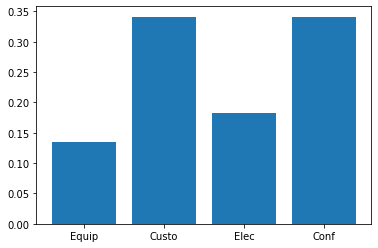

In [22]:
import matplotlib.pyplot as plt
grupos = ['Equip',
          'Custo',
          'Elec',
          'Conf']

valores = [FAHP_CRIT.loc[0,'Equip'],
          FAHP_CRIT.loc[0,'Custo'], 
          FAHP_CRIT.loc[0,'Elec'],
          FAHP_CRIT.loc[0,'Conf']]
plt.bar(grupos, valores)
plt.show()

In [23]:
# APLICAÇÃO DA METOLOGIA AHP/FUZZY NOS CRITÉRIOS - NIVEL 1(EQUIPAMENTOS):
# BLU,
# SPEC45,
# SWG,
# RISER,
# TR TOP
n = 5

B = np.ones([n,n])
for i in range(0,n):
    for j in range(0,n):
        if i<j:
            aij = input('Quão importante é a opção{} da opção{} ?: '.format(i,j))
            B[i,j] = float(aij)
            B[j,i] = round(1/float(aij),1)

Quão importante é a opção0 da opção1 ?: 3
Quão importante é a opção0 da opção2 ?: 0.5
Quão importante é a opção0 da opção3 ?: 2
Quão importante é a opção0 da opção4 ?: 0.5
Quão importante é a opção1 da opção2 ?: 0.5
Quão importante é a opção1 da opção3 ?: 2
Quão importante é a opção1 da opção4 ?: 0.5
Quão importante é a opção2 da opção3 ?: 1
Quão importante é a opção2 da opção4 ?: 0.5
Quão importante é a opção3 da opção4 ?: 0.5


In [62]:
# APLICAÇÃO DA LOGICA FUZZY NO TABELA AHP CRIADA A PARTIR DOS CRITÉRIOS - NIVEL 1
# RESULTADO É OS PESOS DOS CRITÉRIOS - NIVEL 1 (EQUIP)

FAHP_EQUIP = pd.DataFrame({'BLU':[fuzzy_AHP(B)[0]],
                           'SPEC45':[fuzzy_AHP(B)[1]],
                           'SWG':[fuzzy_AHP(B)[2]],
                           'RISER':[fuzzy_AHP(B)[3]],
                           'TR_TOP':[fuzzy_AHP(B)[4]]})
FAHP_EQUIP

[[0.09627810258840414, 0.2033567975843336, 0.46321173695456463], [0.06351985899980175, 0.13104190326828552, 0.3056057756372005], [0.10441088444160036, 0.21540036824066366, 0.43731241594402376], [0.06728174903264898, 0.12371502433190296, 0.28180150350957245], [0.13006786918152202, 0.32648590657481413, 0.6786413371009661]]
[[0.09627810258840414, 0.2033567975843336, 0.46321173695456463], [0.06351985899980175, 0.13104190326828552, 0.3056057756372005], [0.10441088444160036, 0.21540036824066366, 0.43731241594402376], [0.06728174903264898, 0.12371502433190296, 0.28180150350957245], [0.13006786918152202, 0.32648590657481413, 0.6786413371009661]]
[[0.09627810258840414, 0.2033567975843336, 0.46321173695456463], [0.06351985899980175, 0.13104190326828552, 0.3056057756372005], [0.10441088444160036, 0.21540036824066366, 0.43731241594402376], [0.06728174903264898, 0.12371502433190296, 0.28180150350957245], [0.13006786918152202, 0.32648590657481413, 0.6786413371009661]]
[[0.09627810258840414, 0.203356

,BLU,SPEC45,SWG,RISER,TR_TOP
0,0.210259,0.137858,0.208681,0.130315,0.312887


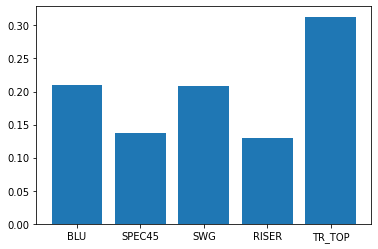

In [25]:
import matplotlib.pyplot as plt
grupos = ['BLU',
          'SPEC45',
          'SWG',
          'RISER',
          'TR_TOP']

valores = [FAHP_EQUIP.loc[0,'BLU'],
          FAHP_EQUIP.loc[0,'SPEC45'], 
          FAHP_EQUIP.loc[0,'SWG'],
          FAHP_EQUIP.loc[0,'RISER'],
          FAHP_EQUIP.loc[0,'TR_TOP']]
plt.bar(grupos, valores)
plt.show()

In [26]:
# APLICAÇÃO DA METOLOGIA AHP/FUZZY NOS CRITÉRIOS - NIVEL 1(CUSTOS):
# CUSTOS DOS EQUIPAMENTOS,
# CUSTOS DOS UMBILICAIS (AQUISIÇÃO E INSTALAÇÃO),
# CUSTO UNITARIO DE CADA ALTERNATIVA
n = 3

C = np.ones([n,n])
for i in range(0,n):
    for j in range(0,n):
        if i<j:
            aij = input('Quão importante é a opção{} da opção{} ?: '.format(i,j))
            C[i,j] = float(aij)
            C[j,i] = round(1/float(aij),1)

Quão importante é a opção0 da opção1 ?: 3
Quão importante é a opção0 da opção2 ?: 0.5
Quão importante é a opção1 da opção2 ?: 0.33


In [63]:
# APLICAÇÃO DA LOGICA FUZZY NO TABELA AHP CRIADA A PARTIR DOS CRITÉRIOS - NIVEL 1
# RESULTADO É OS PESOS DOS CRITÉRIOS - NIVEL 1 (CUSTOS)
FAHP_CUSTO = pd.DataFrame({'TOTAL EQUIP':[fuzzy_AHP(C)[0]],
                           'TOTAL UMB':[fuzzy_AHP(C)[1]],
                           'TOTAL/10':[fuzzy_AHP(C)[2]]})
FAHP_CUSTO

[[0.19383651173320982, 0.33251592768713867, 0.6273440183322085], [0.08805607927829107, 0.13964793890611582, 0.24896163866162635], [0.27956062575710877, 0.5278361334067456, 0.9047866408745509]]
[[0.19383651173320982, 0.33251592768713867, 0.6273440183322085], [0.08805607927829107, 0.13964793890611582, 0.24896163866162635], [0.27956062575710877, 0.5278361334067456, 0.9047866408745509]]
[[0.19383651173320982, 0.33251592768713867, 0.6273440183322085], [0.08805607927829107, 0.13964793890611582, 0.24896163866162635], [0.27956062575710877, 0.5278361334067456, 0.9047866408745509]]


,TOTAL EQUIP,TOTAL UMB,TOTAL/10
0,0.345155,0.142606,0.512239


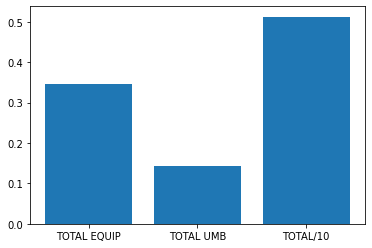

In [28]:
import matplotlib.pyplot as plt
grupos = ['TOTAL EQUIP',
          'TOTAL UMB',
          'TOTAL/10']

valores = [FAHP_CUSTO.loc[0,'TOTAL EQUIP'],
          FAHP_CUSTO.loc[0,'TOTAL UMB'], 
          FAHP_CUSTO.loc[0,'TOTAL/10']]
plt.bar(grupos, valores)
plt.show()

In [29]:
# APLICAÇÃO DA METOLOGIA AHP/FUZZY NOS CRITÉRIOS - NIVEL 1(ELÉTRICOS):
# POTÊNCIA DEMANDADA,
# PERDAS ELÉTRICAS.

n = 2

D = np.ones([n,n])
for i in range(0,n):
    for j in range(0,n):
        if i<j:
            aij = input('Quão importante é a opção{} da opção{} ?: '.format(i,j))
            D[i,j] = float(aij)
            D[j,i] = round(1/float(aij),1)

Quão importante é a opção0 da opção1 ?: 3


In [64]:
# APLICAÇÃO DA LOGICA FUZZY NO TABELA AHP CRIADA A PARTIR DOS CRITÉRIOS - NIVEL 1
# RESULTADO É OS PESOS DOS CRITÉRIOS - NIVEL 1 (ELÉTRICOS)
FAHP_ELET = pd.DataFrame({'Ps':[fuzzy_AHP(D)[0]],
                          'Perd%':[fuzzy_AHP(D)[1]]})
FAHP_ELET

[[0.522407749927483, 0.75, 1.0448154998549657], [0.18469903125906464, 0.25, 0.3693980625181293]]
[[0.522407749927483, 0.75, 1.0448154998549657], [0.18469903125906464, 0.25, 0.3693980625181293]]


,Ps,Perd%
0,0.742386,0.257614


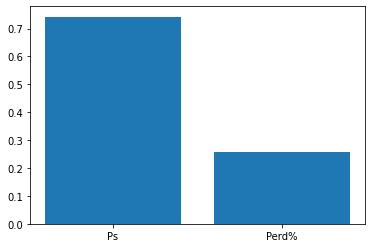

In [31]:
import matplotlib.pyplot as plt
grupos = ['Ps',
          'Perd%']

valores = [FAHP_ELET.loc[0,'Ps'],
          FAHP_ELET.loc[0,'Perd%']]
plt.bar(grupos, valores)
plt.show()

In [32]:
# APLICAÇÃO DA METOLOGIA AHP/FUZZY NOS CRITÉRIOS - NIVEL 1(CONFIABILIDADE):
# CONFIABILIDADE TOTAL PARA 01 CARGA,
# PROBABILIDADE DE PERDA DAS 10 CARGAS.
n = 2

E = np.ones([n,n])
for i in range(0,n):
    for j in range(0,n):
        if i<j:
            aij = input('Quão importante é a opção{} da opção{} ?: '.format(i,j))
            E[i,j] = float(aij)
            E[j,i] = round(1/float(aij),1)

Quão importante é a opção0 da opção1 ?: 0.5


In [65]:
# APLICAÇÃO DA LOGICA FUZZY NO TABELA AHP CRIADA A PARTIR DOS CRITÉRIOS - NIVEL 1
# RESULTADO É OS PESOS DOS CRITÉRIOS - NIVEL 1 (CONFIABILIDADE)

FAHP_CONF = pd.DataFrame({'Conf_S%':[fuzzy_AHP(E)[0]],
                          'Prob_10':[fuzzy_AHP(E)[1]]})
FAHP_CONF

[[0.2113248654051871, 0.3333333333333333, 0.6339745962155614], [0.36602540378443865, 0.6666666666666666, 1.098076211353316]]
[[0.2113248654051871, 0.3333333333333333, 0.6339745962155614], [0.36602540378443865, 0.6666666666666666, 1.098076211353316]]


,Conf_S%,Prob_10
0,0.356147,0.643853


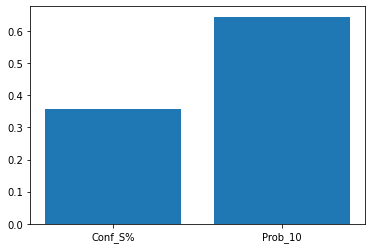

In [34]:
import matplotlib.pyplot as plt
grupos = ['Conf_S%',
          'Prob_10']

valores = [FAHP_CONF.loc[0,'Conf_S%'],
          FAHP_CONF.loc[0,'Prob_10']]
plt.bar(grupos, valores)
plt.show()

In [66]:
# CRIAÇÃO DA TABELA-PESO PARA TODOS OS CRITÉRIOS A PARTIR DOS RESULTADOS AHP/FUZZY

FAHP_PESO = pd.DataFrame({'BLU':[FAHP_CRIT.loc[0, 'Equip']*FAHP_EQUIP.loc[0, 'BLU']],
                         'SPEC45': [FAHP_CRIT.loc[0, 'Equip']*FAHP_EQUIP.loc[0, 'SPEC45']],
                         'SWG': [FAHP_CRIT.loc[0, 'Equip']*FAHP_EQUIP.loc[0, 'SWG']],
                         'RISER':[FAHP_CRIT.loc[0, 'Equip']*FAHP_EQUIP.loc[0, 'RISER']],
                         'TR_TOP':[FAHP_CRIT.loc[0, 'Equip']*FAHP_EQUIP.loc[0, 'TR_TOP']],
                         'TOTAL EQUIP':[FAHP_CRIT.loc[0, 'Custo']*FAHP_CUSTO.loc[0, 'TOTAL EQUIP']],
                         'TOTAL UMB':[FAHP_CRIT.loc[0, 'Custo']*FAHP_CUSTO.loc[0, 'TOTAL UMB']],
                         'TOTAL/10':[FAHP_CRIT.loc[0, 'Custo']*FAHP_CUSTO.loc[0,  'TOTAL/10']],
                         'Ps':[FAHP_CRIT.loc[0, 'Elec']*FAHP_ELET.loc[0,  'Ps']],
                         'Perd%':[FAHP_CRIT.loc[0, 'Elec']*FAHP_ELET.loc[0,  'Perd%']],
                         'Conf_S%':[FAHP_CRIT.loc[0, 'Conf']*FAHP_CONF.loc[0,  'Conf_S%']],
                         'Prob_10':[FAHP_CRIT.loc[0, 'Conf']*FAHP_CONF.loc[0,  'Prob_10']]})
FAHP_PESO

,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,0.028507,0.018691,0.028293,0.017668,0.042422,0.117761,0.048655,0.174767,0.135154,0.0469,0.121511,0.219671


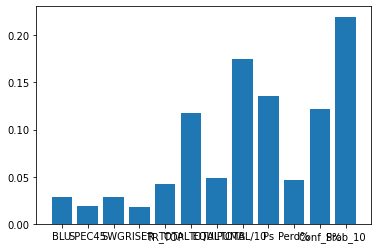

In [49]:
grupos = ['BLU',
          'SPEC45', 
          'SWG',
          'RISER',
          'TR_TOP',
          'TOTAL EQUIP',
          'TOTAL UMB',
          'TOTAL/10',
          'Ps',
          'Perd%',
          'Conf_S%',
          'Prob_10']
valores = [FAHP_PESO.loc[0,'BLU'],
          FAHP_PESO.loc[0,'SPEC45'], 
          FAHP_PESO.loc[0,'SWG'],
          FAHP_PESO.loc[0,'RISER'],
          FAHP_PESO.loc[0,'TR_TOP'],
          FAHP_PESO.loc[0,'TOTAL EQUIP'],
          FAHP_PESO.loc[0,'TOTAL UMB'],
          FAHP_PESO.loc[0,'TOTAL/10'],
          FAHP_PESO.loc[0,'Ps'],
          FAHP_PESO.loc[0,'Perd%'],
          FAHP_PESO.loc[0,'Conf_S%'],
          FAHP_PESO.loc[0,'Prob_10']]
plt.bar(grupos, valores)
plt.show()

In [50]:
# UTLIZANDO A METODOLOGIA TOPIS - NORMALIZA COM RAIZ QUADRADA DA SOMATÓRIA DE CADA CRITÉRIO

nor = pd.DataFrame()
for i in range(0,12):
  aux12 = dd.iloc[i,2:]/res
  nor = nor.append(aux12, ignore_index = True)
nor

,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,0.265207,0.275972,0.0953463,0.0953463,0.172133,0.268921,0.286092,0.271136,0.288077,0.271769,0.157527,0.437438
1,0.277836,0.275972,0.190693,0.190693,0.258199,0.274747,0.288576,0.276536,0.287257,0.29354,0.157527,0.333133
2,0.277836,0.275972,0.190693,0.190693,0.258199,0.278932,0.286708,0.279947,0.286299,0.249573,0.288799,0.182477
3,0.277836,0.275972,0.190693,0.190693,0.258199,0.278832,0.272139,0.277997,0.287462,0.258228,0.196909,0.290975
4,0.277836,0.2972,0.190693,0.190693,0.172133,0.288237,0.301613,0.289969,0.289582,0.289717,0.288799,0.182477
5,0.290465,0.2972,0.286039,0.286039,0.344265,0.294041,0.293096,0.293942,0.289993,0.320196,0.196909,0.20706
6,0.290465,0.2972,0.286039,0.286039,0.258199,0.293952,0.297056,0.294371,0.289582,0.297133,0.288799,0.102812
7,0.290465,0.275972,0.286039,0.286039,0.258199,0.284459,0.26917,0.282525,0.287188,0.270848,0.223163,0.166165
8,0.290465,0.275972,0.286039,0.286039,0.258199,0.284659,0.271318,0.282974,0.286915,0.253661,0.223163,0.166165
9,0.303094,0.2972,0.381385,0.381385,0.344265,0.299668,0.290575,0.298527,0.289787,0.311488,0.223163,0.109934


In [51]:
# UTLIZANDO A METODOLOGIA TOPIS - MULTIPLICA CADA ITEM PELOS PESOS
norpe = pd.DataFrame()
for i in range(0,12):
  aux13 = nor.iloc[i,]*FAHP_PESO
  norpe = norpe.append(aux13, ignore_index = True)
norpe

,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,0.00756034,0.00515821,0.00269767,0.0016846,0.00730217,0.0316684,0.0139197,0.0473857,0.0389348,0.0127458,0.0191413,0.0960927
1,0.00792035,0.00515821,0.00539534,0.00336921,0.0109533,0.0323545,0.0140405,0.0483293,0.0388239,0.0137669,0.0191413,0.0731798
2,0.00792035,0.00515821,0.00539534,0.00336921,0.0109533,0.0328473,0.0139497,0.0489255,0.0386945,0.0117049,0.0350923,0.0400849
3,0.00792035,0.00515821,0.00539534,0.00336921,0.0109533,0.0328355,0.0132408,0.0485848,0.0388516,0.0121108,0.0239266,0.0639188
4,0.00792035,0.00555499,0.00539534,0.00336921,0.00730217,0.033943,0.0146749,0.050677,0.0391382,0.0135876,0.0350923,0.0400849
5,0.00828037,0.00555499,0.00809301,0.00505381,0.0146043,0.0346265,0.0142605,0.0513714,0.0391936,0.0150171,0.0239266,0.045485
6,0.00828037,0.00555499,0.00809301,0.00505381,0.0109533,0.0346161,0.0144531,0.0514463,0.0391382,0.0139354,0.0350923,0.0225848
7,0.00828037,0.00515821,0.00809301,0.00505381,0.0109533,0.0334981,0.0130963,0.0493761,0.0388146,0.0127027,0.0271168,0.0365016
8,0.00828037,0.00515821,0.00809301,0.00505381,0.0109533,0.0335216,0.0132008,0.0494545,0.0387777,0.0118966,0.0271168,0.0365016
9,0.00864039,0.00555499,0.0107907,0.00673842,0.0146043,0.0352891,0.0141378,0.0521727,0.0391659,0.0146087,0.0271168,0.0241493


In [52]:
# UTLIZANDO A METODOLOGIA TOPIS - IDENTIFICA A MELHOR OPÇÃO DE CADA CRITÉRIO
best = pd.DataFrame({'BLU':[norpe['BLU'].min()],
                        'SPEC45':[norpe['SPEC45'].min()],
                        'SWG':[norpe['SWG'].min()],
                        'RISER':[norpe['RISER'].min()],
                        'TR_TOP':[norpe['TR_TOP'].min()],
                        'TOTAL EQUIP':[norpe['TOTAL EQUIP'].min()],
                        'TOTAL UMB':[norpe['TOTAL UMB'].min()],
                        'TOTAL/10':[norpe['TOTAL/10'].min()],
                        'Ps':[norpe['Ps'].min()],
                        'Perd%':[norpe['Perd%'].min()],
                        'Conf_S%':[norpe['Conf_S%'].max()],
                        'Prob_10':[norpe['Prob_10'].min()]})
best

,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,0.00756,0.005158,0.002698,0.001685,0.007302,0.031668,0.013096,0.047386,0.038694,0.011705,0.062209,0.000088


In [53]:
# UTLIZANDO A METODOLOGIA TOPIS - IDENTIFICA A PIOR OPÇÃO DE CADA CRITÉRIO
worst = pd.DataFrame({'BLU':[norpe['BLU'].max()],
                        'SPEC45':[norpe['SPEC45'].max()],
                        'SWG':[norpe['SWG'].max()],
                        'RISER':[norpe['RISER'].max()],
                        'TR_TOP':[norpe['TR_TOP'].max()],
                        'TOTAL EQUIP':[norpe['TOTAL EQUIP'].max()],
                        'TOTAL UMB':[norpe['TOTAL UMB'].max()],
                        'TOTAL/10':[norpe['TOTAL/10'].max()],
                        'Ps':[norpe['Ps'].max()],
                        'Perd%':[norpe['Perd%'].max()],
                        'Conf_S%':[norpe['Conf_S%'].min()],
                        'Prob_10':[norpe['Prob_10'].max()]})
worst

,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,0.009,0.005952,0.013488,0.008423,0.018255,0.03708,0.015179,0.054969,0.039517,0.015734,0.019141,0.096093


In [54]:
# UTLIZANDO A METODOLOGIA TOPIS - CALCULA A DISTÂNCIA EM RELAÇÃO A MELHOR ALTERNATIVA
dbest = pd.DataFrame()
for i in range(0,12):
  aux14 = (norpe.iloc[i,]-best)**2
  dbest = dbest.append(aux14, ignore_index = True)
dbest

,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,0,0,0,0,0,0,6.77901e-07,0,5.77625e-08,1.08365e-06,0.00185484,0.00921684
1,1.29612e-07,0,7.27743e-06,2.83789e-06,1.33304e-05,4.70739e-07,8.91541e-07,8.90447e-07,1.67477e-08,4.25204e-06,0.00185484,0.00534237
2,1.29612e-07,0,7.27743e-06,2.83789e-06,1.33304e-05,1.38985e-06,7.28184e-07,2.37106e-06,0,0,0.00073532,0.00159972
3,1.29612e-07,0,7.27743e-06,2.83789e-06,1.33304e-05,1.36224e-06,2.08787e-08,1.43773e-06,2.46943e-08,1.64783e-07,0.00146555,0.00407433
4,1.29612e-07,1.57438e-07,7.27743e-06,2.83789e-06,0,5.17405e-06,2.49178e-06,1.08323e-05,1.96871e-07,3.5447e-06,0.00073532,0.00159972
5,5.18446e-07,1.57438e-07,2.91097e-05,1.13516e-05,5.33217e-05,8.75082e-06,1.35522e-06,1.5886e-05,2.49165e-07,1.09708e-05,0.00146555,0.00206086
6,5.18446e-07,1.57438e-07,2.91097e-05,1.13516e-05,1.33304e-05,8.68894e-06,1.8409e-06,1.64888e-05,1.96871e-07,4.97541e-06,0.00073532,0.000506092
7,5.18446e-07,0,2.91097e-05,1.13516e-05,1.33304e-05,3.34787e-06,0,3.96152e-06,1.44406e-08,9.95641e-07,0.00123147,0.00132593
8,5.18446e-07,0,2.91097e-05,1.13516e-05,1.33304e-05,3.43455e-06,1.09221e-08,4.28001e-06,6.92124e-09,3.6772e-08,0.00123147,0.00132593
9,1.1665e-06,1.57438e-07,6.54968e-05,2.5541e-05,5.33217e-05,1.31098e-05,1.08462e-06,2.29157e-05,2.22249e-07,8.43205e-06,0.00123147,0.000578933


In [55]:
# UTLIZANDO A METODOLOGIA TOPIS - CALCULA A DISTÂNCIA EM RELAÇÃO A PIOR ALTERNATIVA
dworst = pd.DataFrame()
for i in range(0,12):
  aux15 = (norpe.iloc[i,]-worst)**2
  dworst = dworst.append(aux15, ignore_index = True)
dworst

,BLU,SPEC45,SWG,RISER,TR_TOP,TOTAL EQUIP,TOTAL UMB,TOTAL/10,Ps,Perd%,Conf_S%,Prob_10
0,2.07379e-06,6.29753e-07,0.000116439,4.54063e-05,0.000119974,2.92873e-05,1.58649e-06,5.75128e-05,3.39141e-07,8.93097e-06,0,0
1,1.1665e-06,6.29753e-07,6.54968e-05,2.5541e-05,5.33217e-05,2.2332e-05,1.29662e-06,4.40907e-05,4.80642e-07,3.87071e-06,0,0.000524999
2,1.1665e-06,6.29753e-07,6.54968e-05,2.5541e-05,5.33217e-05,1.79171e-05,1.51184e-06,3.65287e-05,6.76829e-07,1.62365e-05,0.000254436,0.00313687
3,1.1665e-06,6.29753e-07,6.54968e-05,2.5541e-05,5.33217e-05,1.80168e-05,3.75744e-06,4.0764e-05,4.4296e-07,1.31299e-05,2.28993e-05,0.00103516
4,1.1665e-06,1.57438e-07,6.54968e-05,2.5541e-05,0.000119974,9.84152e-06,2.54388e-07,1.84253e-05,1.43637e-07,4.60841e-06,0.000254436,0.00313687
5,5.18446e-07,1.57438e-07,2.91097e-05,1.13516e-05,1.33304e-05,6.02013e-06,8.44136e-07,1.29456e-05,1.04673e-07,5.14424e-07,2.28993e-05,0.00256113
6,5.18446e-07,1.57438e-07,2.91097e-05,1.13516e-05,5.33217e-05,6.07166e-06,5.27234e-07,1.24121e-05,1.43637e-07,3.23602e-06,0.000254436,0.00540341
7,5.18446e-07,6.29753e-07,2.91097e-05,1.13516e-05,5.33217e-05,1.28311e-05,4.3385e-06,3.12857e-05,4.93544e-07,9.19084e-06,6.3609e-05,0.0035511
8,5.18446e-07,6.29753e-07,2.91097e-05,1.13516e-05,5.33217e-05,1.26631e-05,3.91406e-06,3.04142e-05,5.46864e-07,1.47279e-05,6.3609e-05,0.0035511
9,1.29612e-07,1.57438e-07,7.27743e-06,2.83789e-06,1.33304e-05,3.20778e-06,1.08462e-06,7.82143e-06,1.23386e-07,1.26711e-06,6.3609e-05,0.00517584


In [ ]:
(dworst.iloc[0,].sum())**0.5/((dbest.iloc[0,].sum())**0.5+(dworst.iloc[0,].sum())**0.5)

0.06525586766033885

In [56]:
# UTLIZANDO A METODOLOGIA TOPIS - CALCULA A PONTUAÇÃO FINAL PARA CADA ALTERNATIVA
drank = pd.DataFrame()
for i in range(0,12):
  aux16 = pd.DataFrame({'EQUIP':[dd.loc[i,'EQUIP']],'Rank':[(dworst.iloc[i,].sum())**0.5/((dbest.iloc[i,].sum())**0.5+(dworst.iloc[i,].sum())**0.5)]})
  drank = drank.append(aux16, ignore_index = True)
drank

,EQUIP,Rank
0,10,0.156671
1,8X2,0.242814
2,7X3,0.552780
3,6X4,0.324137
4,5X5,0.553448
5,2X2X6,0.460207
6,2X3X5,0.675875
7,2X4X4,0.545288
8,3X3X4,0.545450
9,2X2X2X4,0.618837


In [57]:
# UTLIZANDO A METODOLOGIA TOPIS - ENCONTRA-SE A O RANKING FINAL
drank.sort_values(by = 'Rank', ascending = False, ignore_index = True)

,EQUIP,Rank
0,2X2X3X3,0.870437
1,2X2X2X2X2,0.841537
2,2X3X5,0.675875
3,2X2X2X4,0.618837
4,5X5,0.553448
5,7X3,0.552780
6,3X3X4,0.545450
7,2X4X4,0.545288
8,2X2X6,0.460207
9,6X4,0.324137


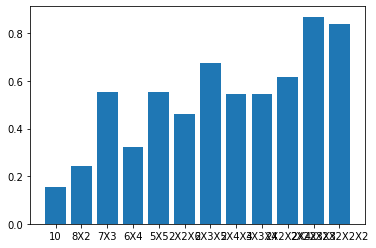

In [59]:
grupos = ['10',
          '8X2', 
          '7X3',
          '6X4',
          '5X5',
          '2X2X6',
          '2X3X5',
          '2X4X4',
          '3X3X4',
          '2X2X2X4',
          '2X2X3X3',
          '2X2X2X2X2']
valores = [drank.loc[0,'Rank'],
          drank.loc[1,'Rank'], 
          drank.loc[2,'Rank'],
          drank.loc[3,'Rank'],
          drank.loc[4,'Rank'],
          drank.loc[5,'Rank'],
          drank.loc[6,'Rank'],
          drank.loc[7,'Rank'],
          drank.loc[8,'Rank'],
          drank.loc[9,'Rank'],
          drank.loc[10,'Rank'],
          drank.loc[11,'Rank']]
plt.bar(grupos, valores)
plt.show()